In [125]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
import corner
import time
from chainconsumer import ChainConsumer
from chainconsumer import analysis

## *What is the problem?*
### Evaluating a function $P(\theta | \rm{other\ stuff})$ as a function of $\theta$ (e.g. posterior probability of parameters)

In [152]:
def log_function_nd(theta):
    """
    This function is an arbitrary function as a placeholder for an n-dimensional posterior (not normalised)
    """
    dim = np.array(theta).shape[0]   
    cov_diag = np.linspace(0.1,0.15, dim)*0.01 + 0.2
    y_vec = np.linspace(0.1,0.15, dim)**np.linspace(0.1,0.11, dim) + 1.0
    log_residual = np.log(np.abs(theta)) - y_vec
    
    # sneaky extra time for calculation
#     time.sleep(1e-4)
    
    return - np.inner(log_residual, log_residual / cov_diag) 

In [347]:
# priors for all parameters
prior_min, prior_max = 0.0, 19.0

# number of grid points per dimension
n_grid = 20

## One dimension

In [348]:
theta_0_1d = np.linspace(prior_min,prior_max,n_grid)

print(theta_0_1d)

log_posterior_1d = np.zeros(theta_0_1d.shape)

for i in range(len(log_posterior_1d)):
    log_posterior_1d[i] = log_function_nd([theta_0_1d[i]])


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


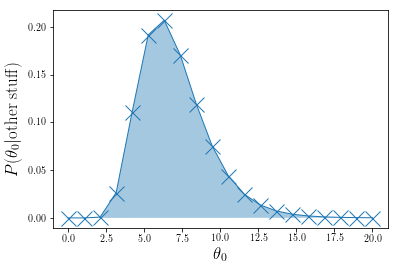

In [333]:
_ = plt.fill(theta_0_1d, np.exp(log_posterior_1d)/np.sum(np.exp(log_posterior_1d)), alpha = 0.4)
_ = plt.plot(theta_0_1d, np.exp(log_posterior_1d)/np.sum(np.exp(log_posterior_1d)), marker = 'x', ms = 15,  lw=1)
_ = plt.ylabel(r'$P(\theta_0| \rm{other\ stuff})$', fontsize = 17), plt.xlabel(r'$\theta_0$', fontsize = 17)

## 2D grid (15 x 15 = 225 evaluations of the posterior)

In [156]:
theta_0, theta_1 = np.mgrid[prior_min:prior_max:n_grid*1j,prior_min:prior_max:n_grid*1j]
theta_0 = theta_0.flatten()
theta_1 = theta_1.flatten()

In [157]:
log_posterior = np.zeros(theta_0.shape)

for i in range(len(log_posterior)):
    log_posterior[i] = log_function_nd([theta_0[i], theta_1[i]])

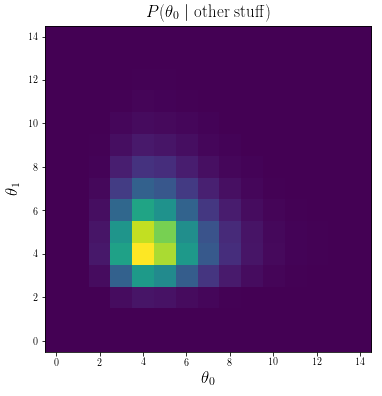

In [158]:
_ = plt.figure(figsize = (6,6))
_ = plt.imshow(np.exp(np.reshape(log_posterior, (n_grid,n_grid))).T, origin = 'lower')
_ = plt.xlabel(r'$\theta_0$', fontsize = 17), plt.ylabel(r'$\theta_1$', fontsize = 17)
_ = plt.title(r'$P(\theta_0\ |\ \rm{other\ stuff})$', fontsize = 17)

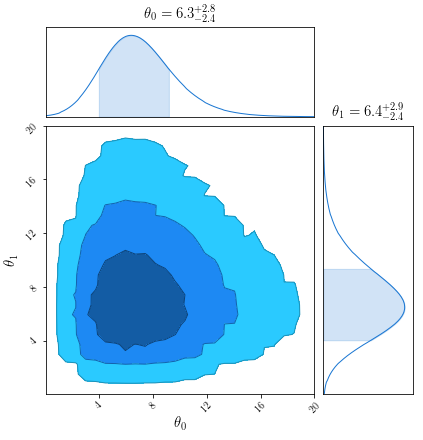

In [159]:
c = ChainConsumer()

weights_array1 = np.reshape(np.exp(log_posterior),-1)
weights_array1 += np.min(weights_array1[np.where(weights_array1>0)])

c.add_chain([theta_0, theta_1],
            parameters=[r'$\theta_0$', r'$\theta_1$'],
            weights=weights_array1, grid=True)


c.configure(kde= [1.], sigmas = [1,2, 3],
            contour_label_font_size = 19,
            label_font_size = 15, shade = True)

fig = c.plotter.plot(figsize = (6,6))

## 6 dimensions (e.g. 15^6 ~ 11 million evaluations of the posterior)

In [171]:
theta_0, theta_1, theta_2, theta_3,\
theta_4, theta_5 = np.mgrid[prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j,
                            prior_min:prior_max:n_grid*1j]

theta_0 = theta_0.flatten()
theta_1 = theta_1.flatten()
theta_2 = theta_2.flatten()
theta_3 = theta_3.flatten()
theta_4 = theta_4.flatten()
theta_5 = theta_5.flatten()

In [172]:
# This will take forever

log_posterior_6d = np.zeros(theta_0.shape)

for i in range(len(log_posterior_6d)):
    log_posterior_6d[i] = log_function_nd([theta_0[i],
                                           theta_1[i],
                                           theta_2[i],
                                           theta_3[i],
                                           theta_4[i],
                                           theta_5[i]])

KeyboardInterrupt: 

In [173]:
print(i)

205237


# MCMC to the rescue!

In [174]:
def initial_parameters(theta, relative_sigma):
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [175]:
n_dim6d=6
n_burn6d=100
n_steps6d = 4000
n_walkers6d = 2 * n_dim6d

In [176]:
theta6d_expected_mean = [10]*n_dim6d

theta_init_6d = [list(initial_parameters(theta6d_expected_mean, 0.1)) for i in range(n_walkers6d)]

In [177]:
def posterior6d_hard_prior(theta, prior_min, prior_max):
#     print(theta)
    if any(val > prior_max for val in theta):
#         print(theta)
        return 1e18*(log_function_nd(theta))
    elif any(val < prior_min for val in theta):
#         print(theta)
        return 1e18*(log_function_nd(theta))
    else:
        return (log_function_nd(theta))
    

sampler6d = mc.EnsembleSampler(n_walkers6d, n_dim6d, posterior6d_hard_prior,
                             args=(prior_min, prior_max))

In [178]:
print('burning')
startTime=time.time()
pos, prob, state =  sampler6d.run_mcmc(theta_init_6d, n_burn6d)
read_chain=np.array(sampler6d.chain[:,:,:])
endTime=time.time()
totalTime=endTime-startTime
print(totalTime)

burning
0.2375650405883789


In [182]:
# sampler.reset() #lose the written chain
t = time.time()
pos,prob,state=sampler6d.run_mcmc(pos, n_steps6d) #start from where we left off previously 

print(time.time() - t)
read_chain=np.array(sampler6d.chain[:,n_burn6d:,:]) #get chain for writing
read_chain=read_chain.astype(float)


5.943969011306763


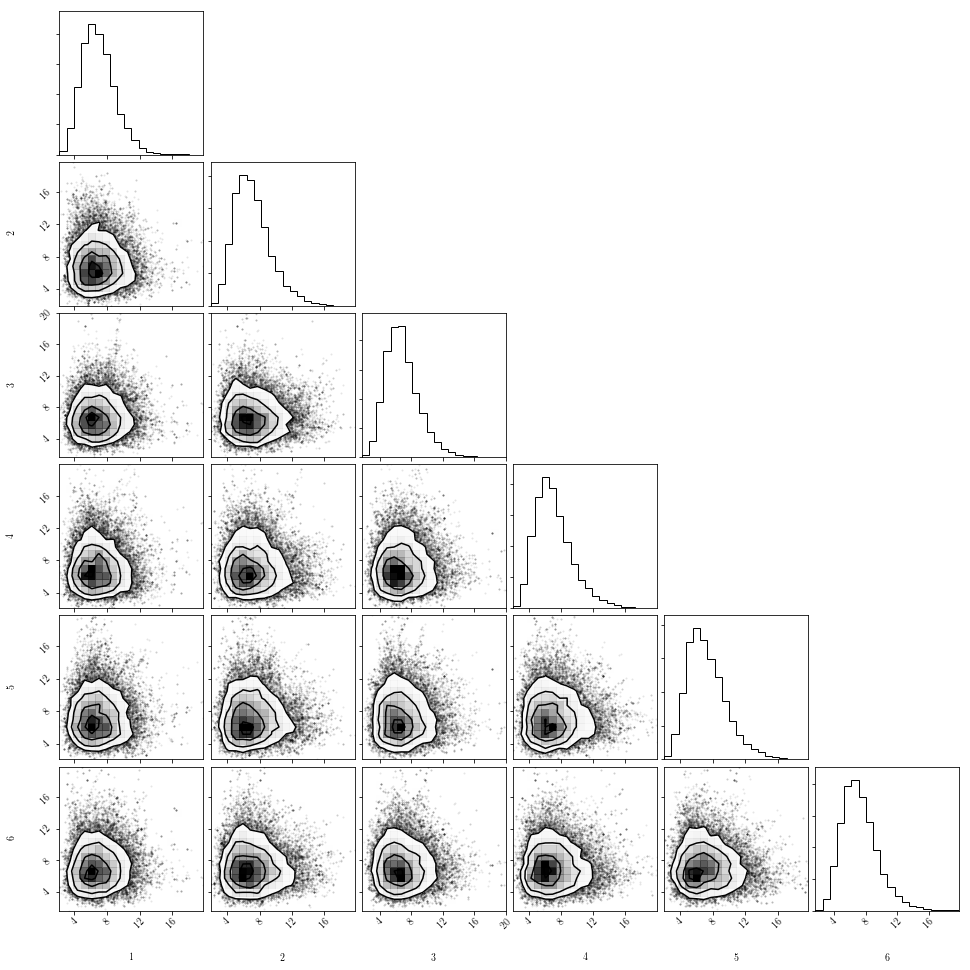

In [183]:
samples6d = read_chain.reshape((-1, n_dim6d))
fig = corner.corner(samples6d, labels=['1', '2', '3', '4', '5', '6'])

## Use it for the low dimensional stuff?

In [535]:
n_burn1d=1000
n_steps1d = 1200
n_samples1d = 2 * (n_steps1d - n_burn1d)

print('Number of samples = ' + str(n_samples1d))

theta_init_1d = [list(initial_parameters([10], 0.1)) for i in range(2)]

Number of samples = 400


In [531]:
sampler1d = mc.EnsembleSampler(n_walkers1d, 1, posterior6d_hard_prior,
                             args=(prior_min, prior_max))


In [532]:
pos, prob, state =  sampler1d.run_mcmc(theta_init_1d, n_steps1d)
samples1d=np.array(sampler1d.chain[:,n_burn1d:,:]).flatten()

In [533]:
theta_0_1d_fine = np.linspace(prior_min,prior_max,n_grid*10-9)

log_posterior_1d_fine = np.zeros(theta_0_1d_fine.shape)

for i in range(len(log_posterior_1d_fine)):
    log_posterior_1d_fine[i] = log_function_nd([theta_0_1d_fine[i]]) 


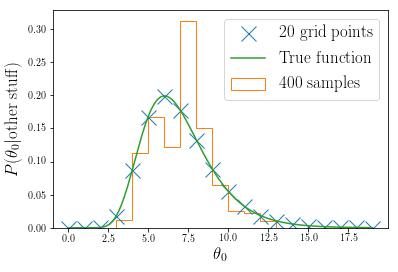

In [542]:
_ = plt.plot(theta_0_1d, np.exp(log_posterior_1d)/np.sum(np.exp(log_posterior_1d)), marker = 'x', ms = 15,  lw=0, label = '20 grid points')
_ = plt.hist(samples1d, normed = True, histtype ='step', bins = np.linspace(0,19,20), label = str(n_samples1d) + ' samples')
_ = plt.plot(theta_0_1d_fine, 10.0*np.exp(log_posterior_1d_fine)/np.sum(np.exp(log_posterior_1d_fine)),  label = 'True function')
_ = plt.ylabel(r'$P(\theta_0| \rm{other\ stuff})$', fontsize = 17), plt.xlabel(r'$\theta_0$', fontsize = 17)
_ = plt.legend(fontsize = 17)

# If the samples match the underlying distribution, the MCMC has "converged"